## Model Score Comparisons

The purpose of this notebook to show the model score comparisons. I have run the detection and recognition models on the data collected from the office and printed their accuracy vs model scores. 

The detection model labeled as "Frontal" is the detection model we use right now, it doesn't run on GPU.
The recognition model labeled as "Resnet" is the recognition model we use right now, it doesn't run on GPU.
The rest of the models can run on GPU/CPU. I included the original models to see how their performances compare. 

Currently, there two models that perform pretty well (based on the best f1 score) which are: 

<b>Model 1:</b>
 - Detection : frontal 
 - Recognition: facenet
 - Number of detected images: 43/137
 - Accuracy: 93%
 
<b>Model 2:</b>
 - Detection : mtcnn 
 - Recognition: facenet
 - Number of detected images: 100/137
 - Accuracy: 90%
 
Even though the Model 1 has a higher accuracy, the number of detected faces is less than half of the detected faces in the second model. The second model can fully run on GPU. The first model's detection model can only be run on CPU. I haven't run the CPU models in parallel yet, but it seems like we'll get the best performance out of the <b>Model 2</b> since it can fully run on GPU.

The Openface model does pretty poorly on our dataset. In their model benchmarks (using LFW dataset) the accuracy was ~6% lower than the Facenet, but it is much lower in our case. I think we should rule out the Openface model as an option.

<b>Improvements:</b>
 - I was able to improve the models with minor improvements (standardizing the image, cropping the face in a square format instead of rectangle box to resist to resizing, normalizing the embeddings etc.). I am not doing any preprocessing on the images such as smoothing, prewhitening etc. These methods can also be explored in the future.  


<b>The logic I followed to generate these results: </b>
 1. Pick an anchor image that looks the best for each person. 
 2. Run the detection and recognition models on the anchor images and create the database of faces to check against
 3. Loop through the total dataset and run the same detection and recognition models and generate distances and labels (1 if it matches the anchor image, 0 if not). 
 4. Create a threshold range (see below) and run the predictions
 5. Find the best threshold for the models that maximizes the f1 score. Recognition models have different embedding outputs. Therefore, the distance thresholds change from model to model. 

The FaceNet paper recommends 1.1 and in the plots below, you can see the best results are around 1.1 threshold. The recommended threshold for our original Resnet model is 0.6, but as you can see in the plot below (Frontal, Resnet plot), the 0.79 threshold has a better result.

<b> Things that I am not doing: </b>
- removed the min face height pixel criteria to see how the small images do
- collecting 4 images and averaging them. Currently I have one image per anchor photo which is handpicked

In [1]:
import os
import csv
import cv2
import numpy as np
import pandas as pd
import glob
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [2]:
path = '../results/'

In [3]:
thresholds = np.arange(0.3, 2.0, 0.01)

In [16]:
def plot(filename, data, thresholds):  
    pred = data['identification']
    distances = data['distance']
    
    f1_scores = [f1_score(pred, distances < t) for t in thresholds]
    precision = [precision_score(pred, distances < t) for t in thresholds]
    recall = [recall_score(pred, distances < t) for t in thresholds]
    acc_scores = [accuracy_score(pred, distances < t) for t in thresholds]
    
    title = 'detection: %s recognition: %s dataset: %s num_of_detections: %s' % (filename.split("_")[0], filename.split("_")[1], filename.split("_")[2], filename.split("_")[3])
    scores = {'f1': f1_scores, 'precision': precision, 'recall' :recall}
    fig, axs = plt.subplots(1,3, figsize=(20, 5), facecolor='w', edgecolor='k')
    if set(filename.split("_")[:3]) == set(['mtcnn', 'facenet', 'office']) or set(filename.split("_")[:3]) == set(['frontal', 'facenet', 'office']): 
        fig.suptitle(title, fontsize=16, color='red', fontweight='bold')
    else:
        fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(hspace = 0.1, wspace=.1)
    axs = axs.ravel()
    for i, key in enumerate(scores):
        d = scores[key]
        optimum_id = np.argmax(scores[key])
        optimum_threshold = thresholds[optimum_id]
        optimum_accuracy = accuracy_score(pred, distances < optimum_threshold)
        axs[i].plot(thresholds, scores[key], label=key);
        axs[i].plot(thresholds, acc_scores, label='Accuracy');
        axs[i].axvline(x=optimum_threshold, linestyle='--', lw=1, c='lightgrey', label='Threshold')
        axs[i].set_title('Accuracy %.3f at maximum %s (%.2f), threshold %.2f' % (optimum_accuracy, key, scores[key][optimum_id], optimum_threshold))
        axs[i].set_xlabel('threshold')
        axs[i].legend();

<b>How to read the plots</b>

The plots are pretty long, so it might be a little hard to read. There were so many models to compare! 
There is one big title for each row of plots that denotes the detection and recognition models used along with the number of detections and the dataset used. 
The first plot is the f1 score vs accuracy plot. The threshold is picked based on the highest f1.
The second and third plots are the precision/recall score vs accuracy plots. The threshold is picked based on the highest precision/recall. Since argmax picks the first id the maximum values, the accuracies are not at the highest point, but since I am optimizing for f1, I didn't mess with those results.

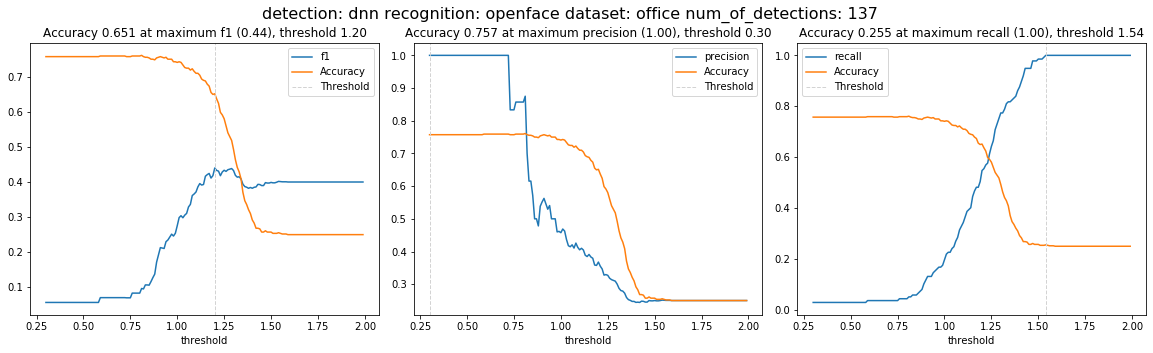

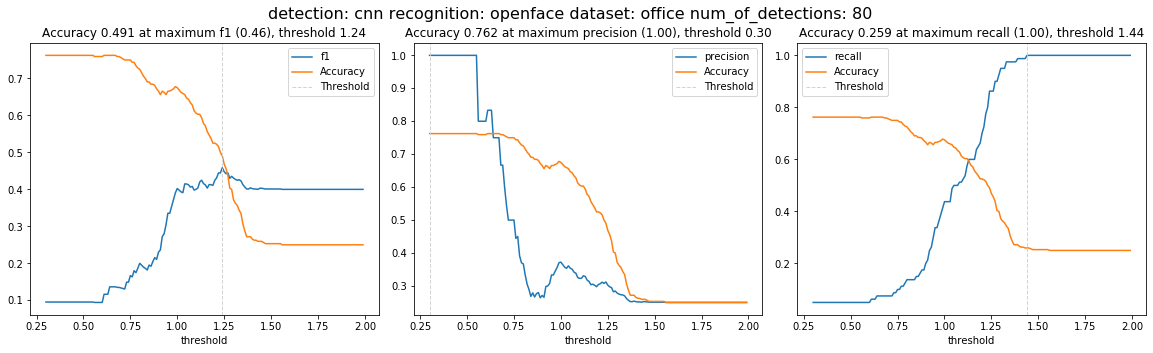

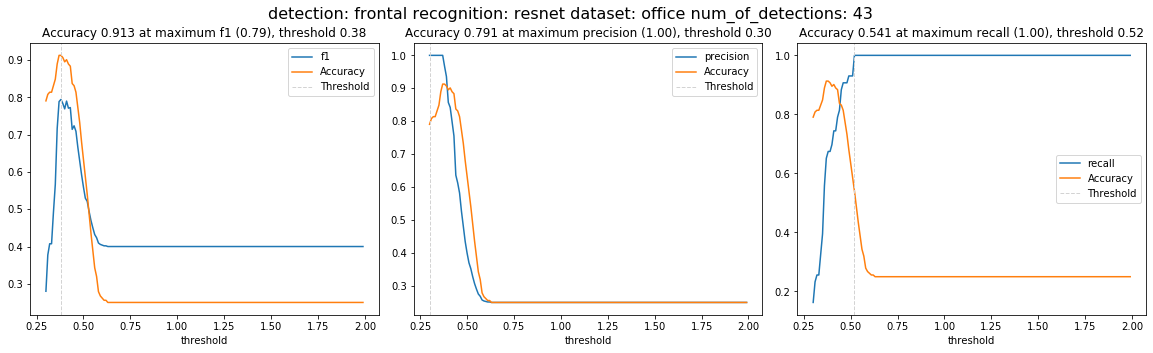

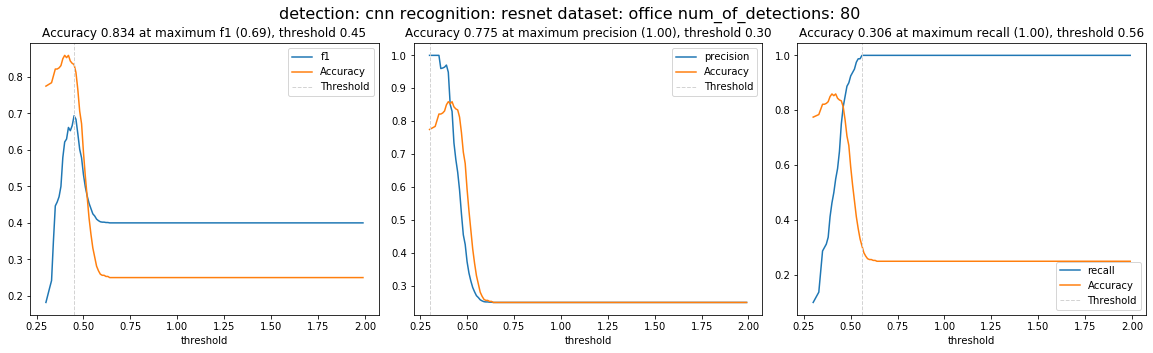

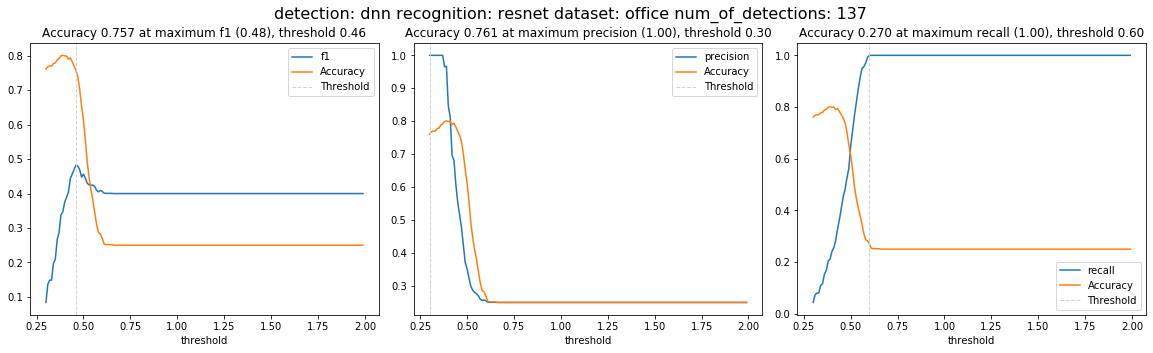

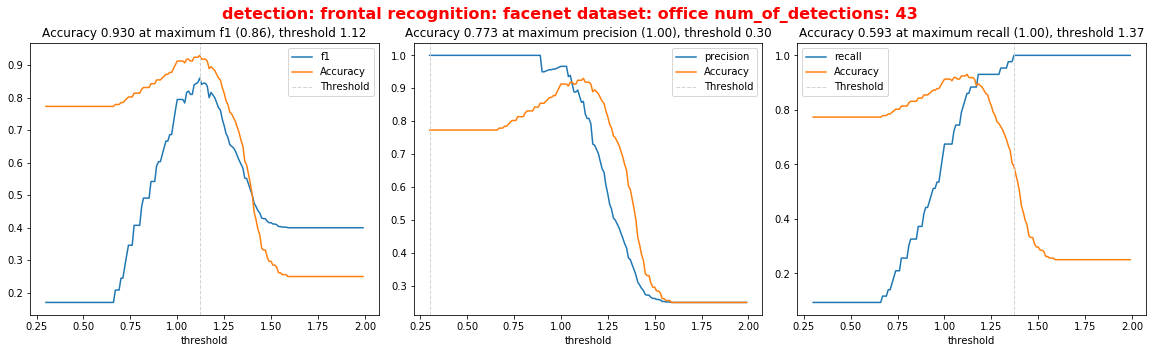

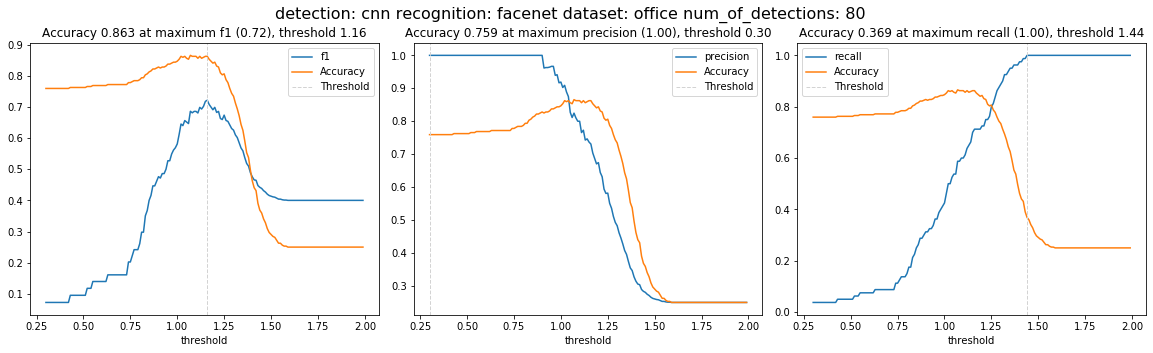

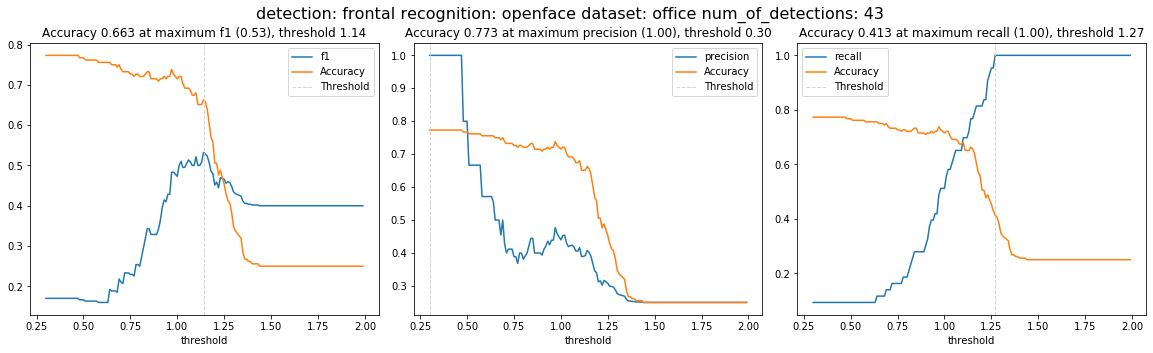

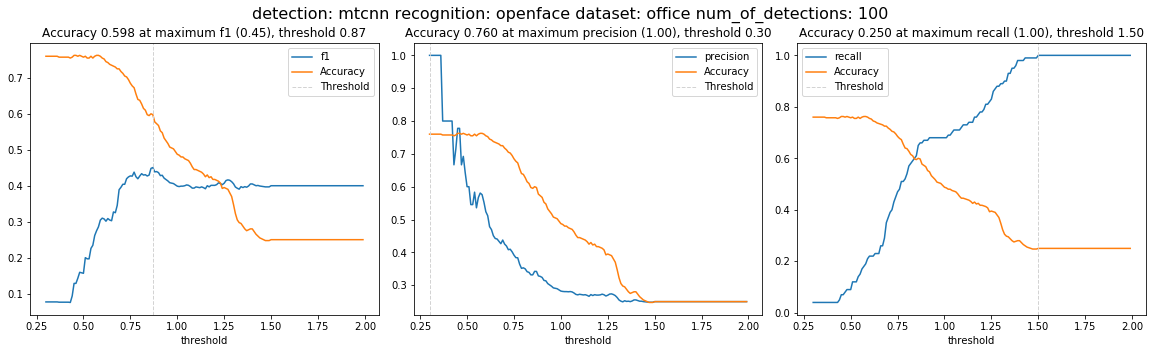

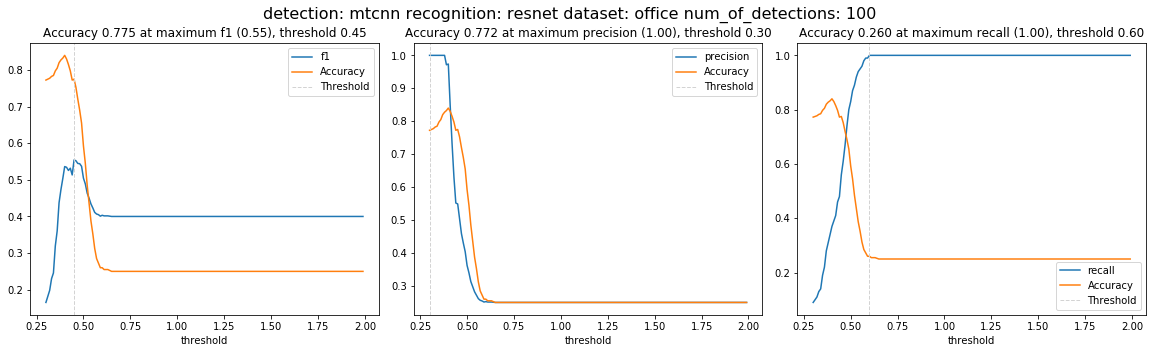

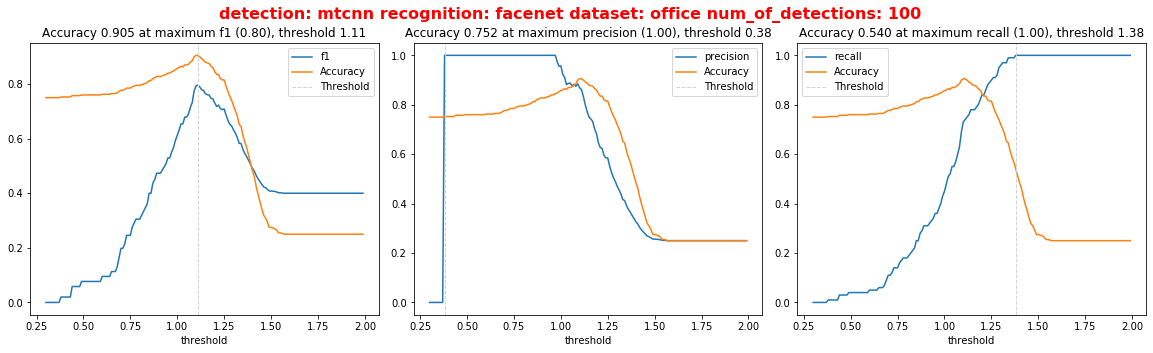

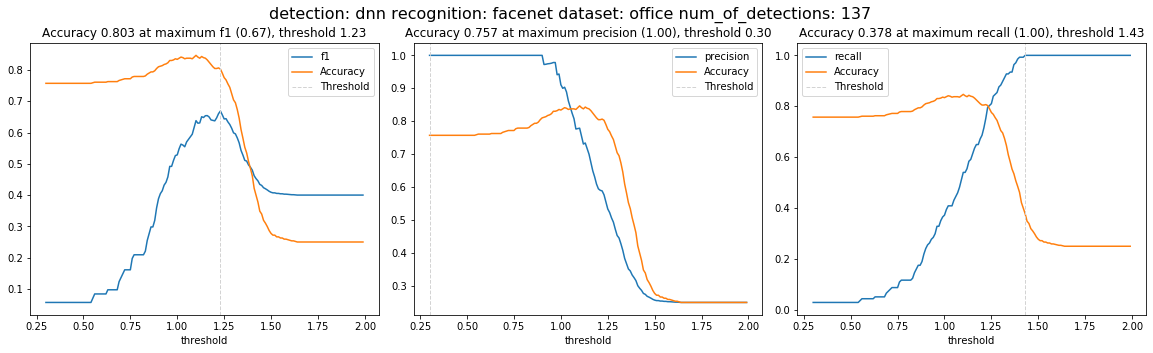

In [17]:
files = glob.glob(os.path.join(path, '*office*'))
for filename in files:
    data = np.genfromtxt(os.path.join(path, filename), delimiter=',', names=True) 
    plot(os.path.basename(filename).split('.')[0], data, thresholds)

### Bonus Model

I have found another open source project for mtcnn and facenet models. The example I have found does some preprocessing on the face images (such as prewhitening) before sending to the recognition model. The pretrained mtcnn model is different than the mtcnn model above. This one could detect 67 images which is less than mtcnn model I have been using (available on pip). 

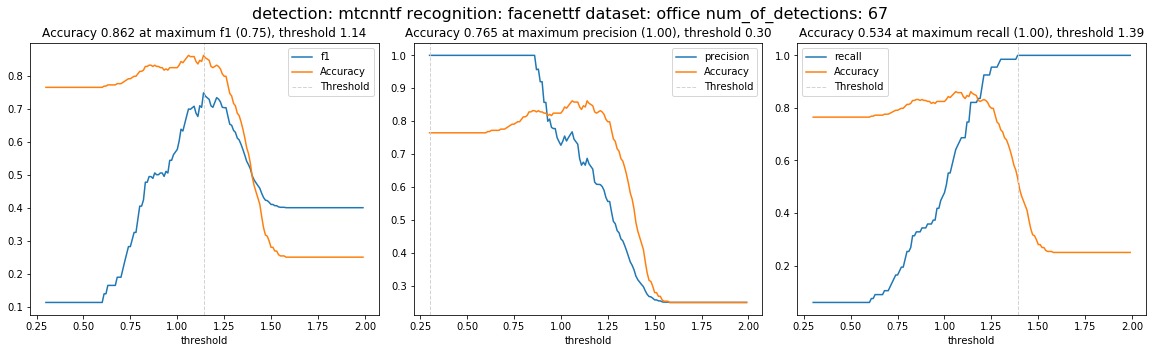

In [6]:
filename = os.path.join(path, 'bonus/mtcnntf_facenettf_office_67.csv')
data = np.genfromtxt(os.path.join(path, filename), delimiter=',', names=True) 
plot(os.path.basename(filename).split('.')[0], data, thresholds)

### Model Comparisons on Celebrity Images

I created another dataset to test if my models are being run correctly. The celebrity dataset has some random celebrity images I found online and images that I retrieved from LFW dataset which is the dataset is used for benchmarking these recognition models. As you can see the models have almost 100% accuracy for the celebrity dataset. Since our images are small and blurry, it is expected to have worse performance. One thing we can try is to retrain these models (facenet, openface) with smaller images (using the same LFW training data or another open dataset) and see if they do better. 

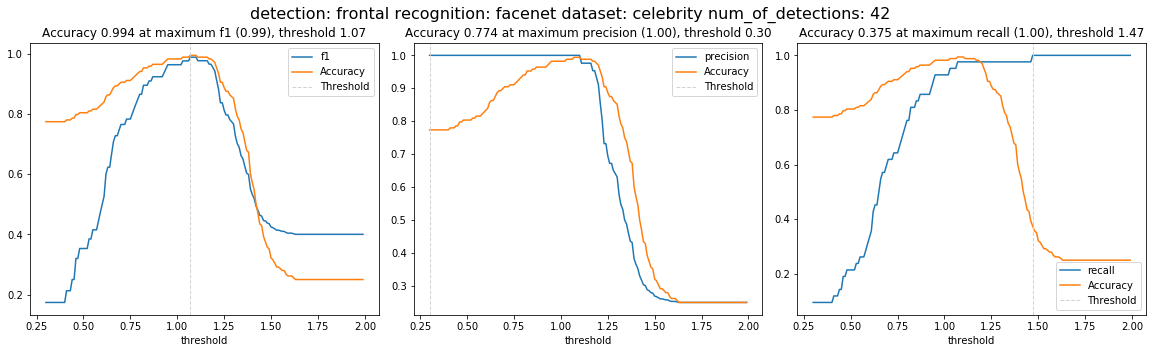

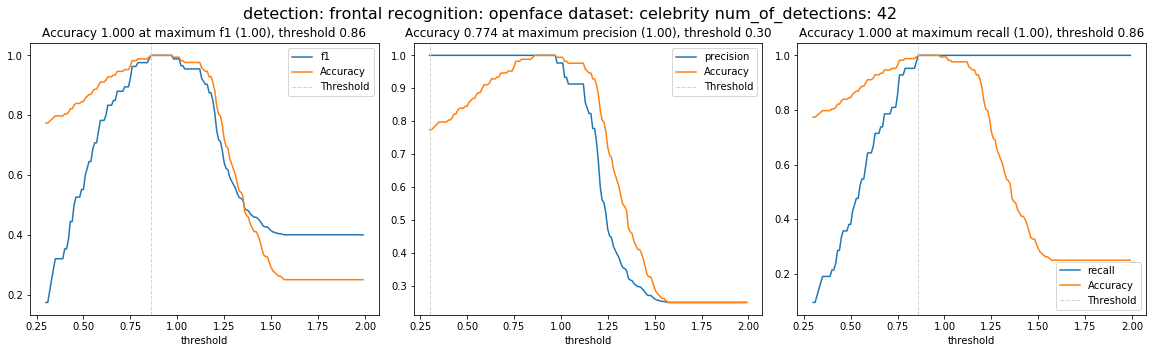

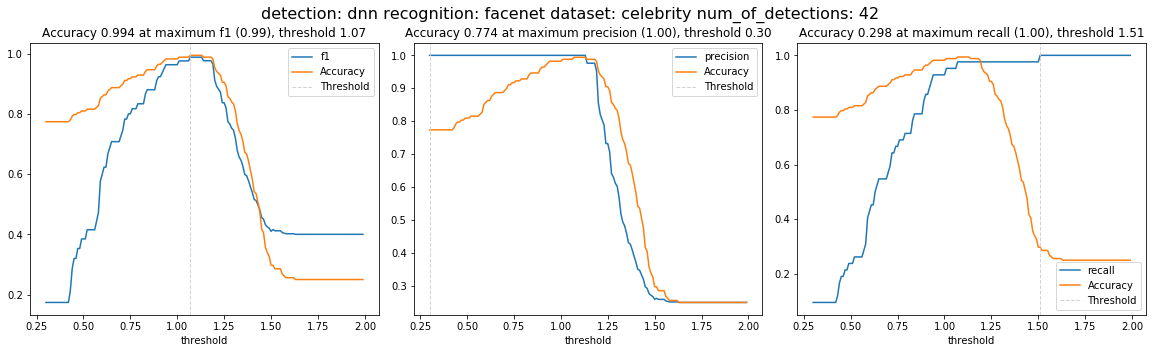

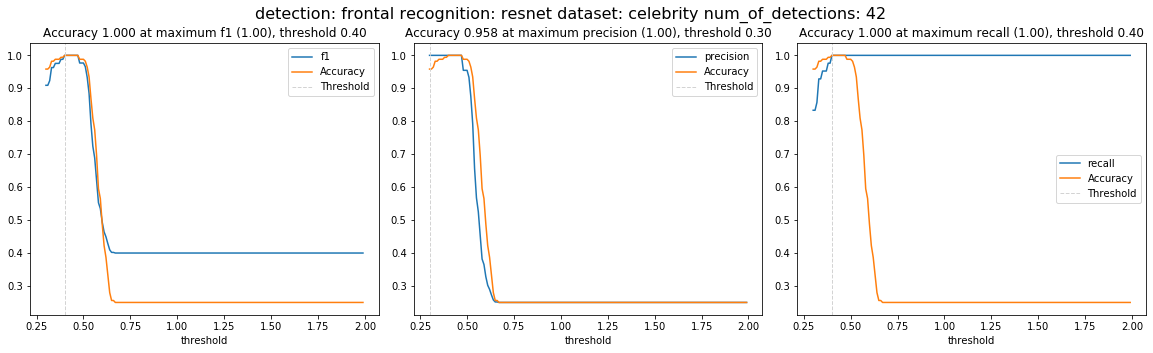

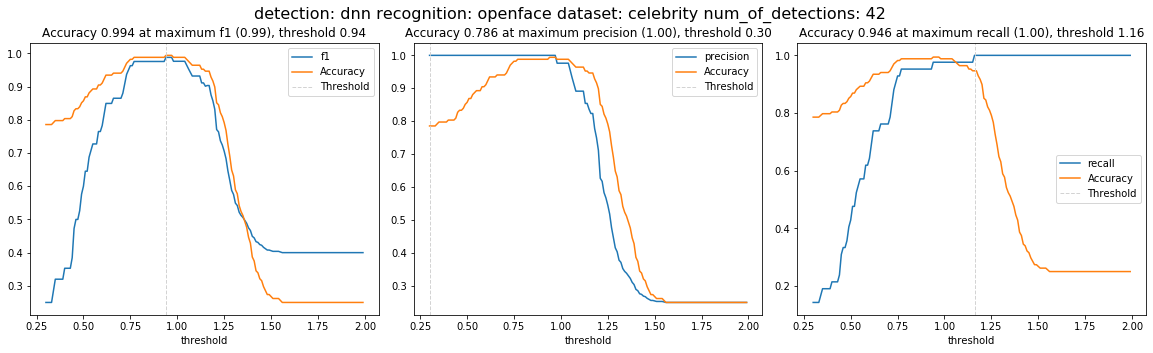

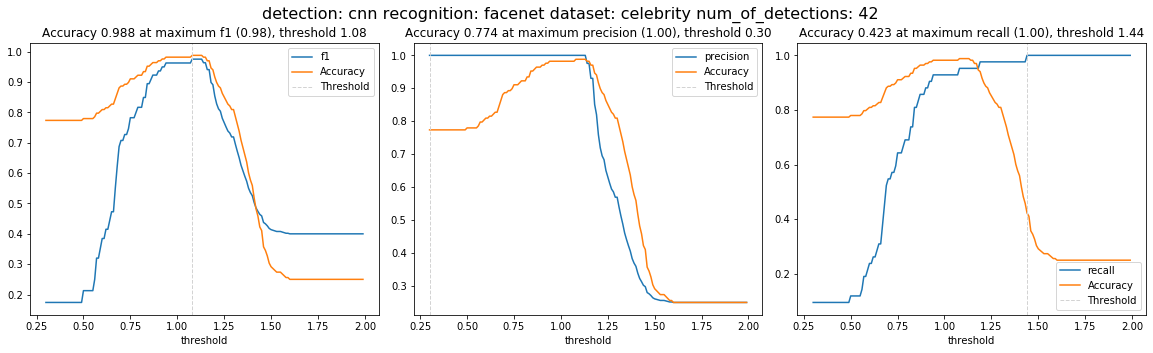

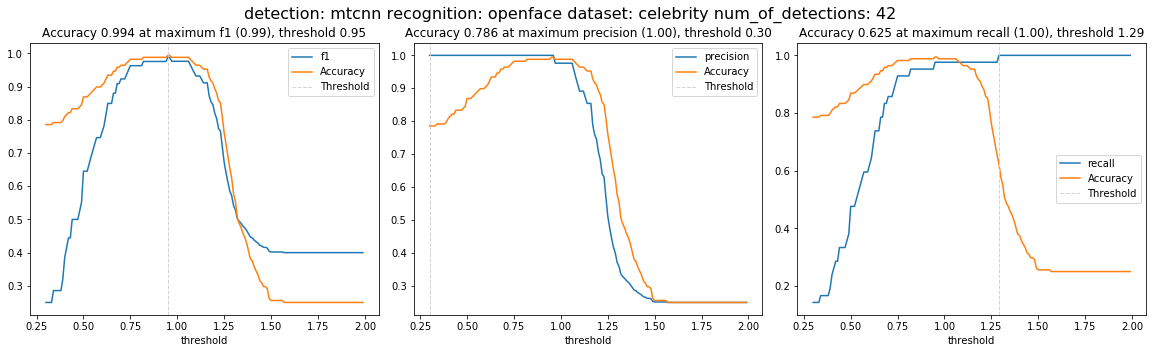

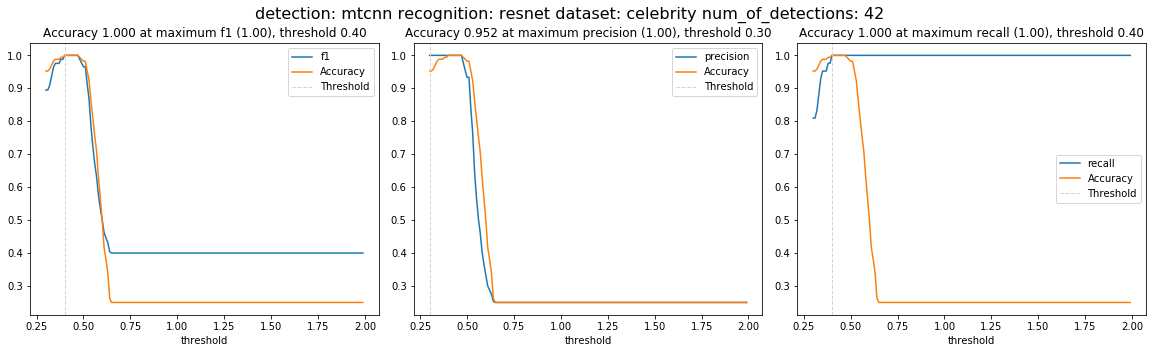

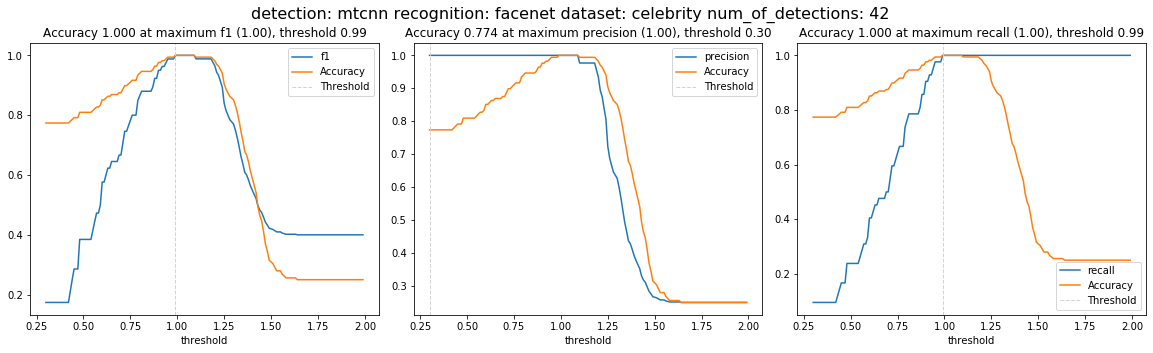

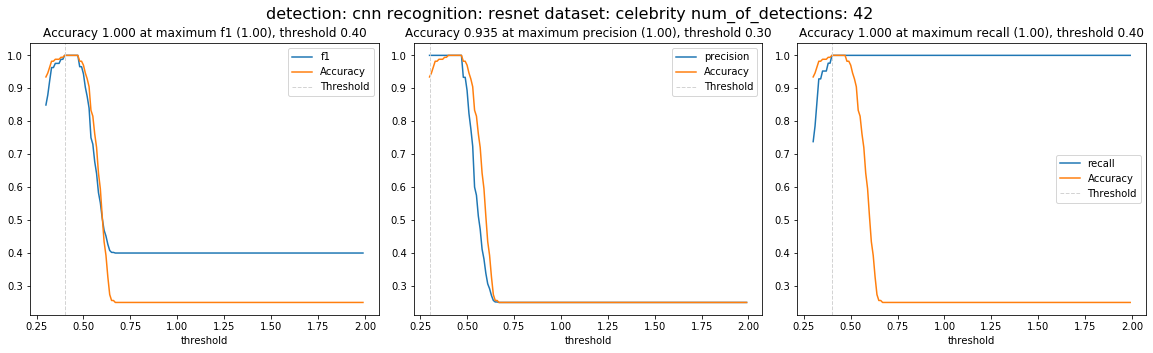

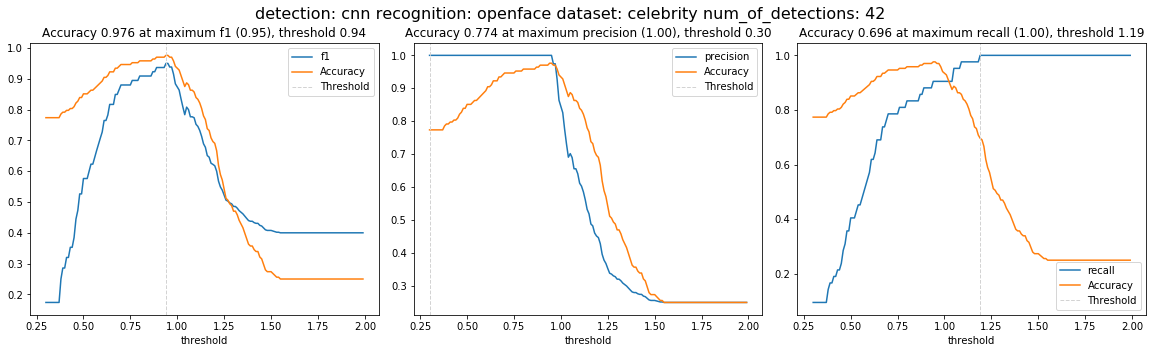

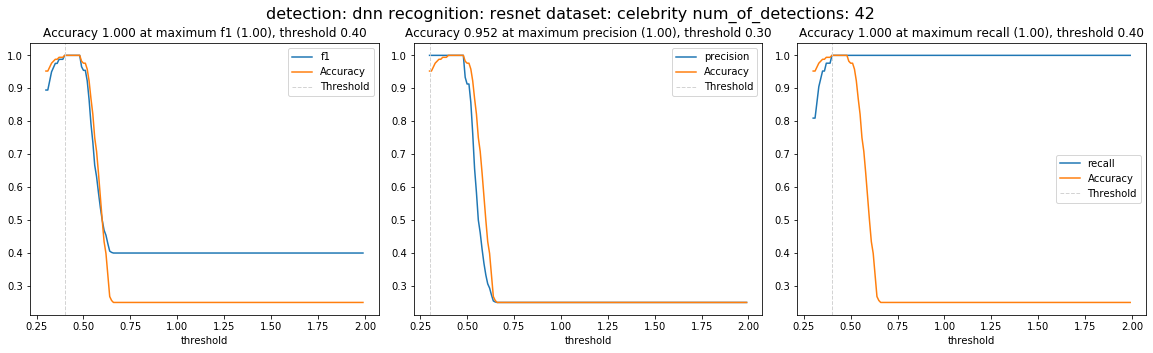

In [7]:
celebrity_files = glob.glob(os.path.join(path, '*celebrity*'))
for filename in celebrity_files:
    data = np.genfromtxt(filename, delimiter=',', names=True) 
    plot(os.path.basename(filename).split('.')[0], data, thresholds)